In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# !cp -r drive/MyDrive/ift714/ift714-project/* .
colab = False

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

### Load models

In [3]:
import torch.nn as nn
import torch

In [4]:
if torch.cuda.is_available():
    # Use the GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    # Use the CPU
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
!pip install 'transformers[torch]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.6 MB/s eta 0:00:00


In [6]:
# loading pre-trained models
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoTokenizer,
    )
from torch.optim.adamw import AdamW

In [7]:
# model_name = "distilbert-base-uncased"
model_name = "distilbert-base-cased"


In [8]:
bert_model = DistilBertForSequenceClassification.from_pretrained(model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                            num_labels = 4,      # The number of output labels
                                            output_attentions = False, # Whether the model returns attentions weights.
                                            output_hidden_states = False # Whether the model returns all hidden-states.
                                            )

bert_tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tell pytorch to run this model on the GPU.
if torch.cuda.is_available():
    bert_model.cuda()

print(' Base models loaded')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

 Base models loaded


In [9]:
from src.utils.model_utils import create_data_loader

# function to seed the script globally
random_state = 17
torch.manual_seed(random_state)

## Training

In [10]:
if colab:
    train_extra_file = "./data/proc/training_extra.parquet.gzip"
    train_file = "./data/proc/training.parquet.gzip"
else:
    train_extra_file = "./../../data/proc/training_extra.parquet.gzip"
    train_file = "./../../data/proc/training.parquet.gzip"

### Load training data

In [11]:
from src.utils.data_utils import prepare_data

In [12]:
# train_df = pd.read_parquet(train_extra_file)
train_df = pd.read_parquet(train_file)
class_counts = train_df['rating'].value_counts()
class_counts

1    461
2    211
0    138
3     74
Name: rating, dtype: int64

## Deal with imbalanced set

In [13]:
# The classes are the index
sorted_classes = class_counts.sort_index()
display(sorted_classes)

print()
print("Weights based on the distribution of classes")
weight = (1/class_counts.shape[0])*(1 / (sorted_classes.values / np.sum(sorted_classes.values)))
display(weight)

print()
print("Artificially balanced set")
display(sorted_classes * weight)

# Convert to torch.Tensor
weight = torch.Tensor(weight)
weight

0    138
1    461
2    211
3     74
Name: rating, dtype: int64


Weights based on the distribution of classes


array([1.60144928, 0.47939262, 1.04739336, 2.98648649])


Artificially balanced set


0    221.0
1    221.0
2    221.0
3    221.0
Name: rating, dtype: float64

tensor([1.6014, 0.4794, 1.0474, 2.9865])

Extract numpy arrays from dataframes

In [14]:
use_sample = False
sample_size = 100

feature='title'

if use_sample:
    x_train = train_df['title'].values[:sample_size]
    y_train = train_df['rating'].values[:sample_size].astype('int64')
else:
    x_train = train_df['title'].values
    y_train = train_df['rating'].values.astype('int64')

## Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values :
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We chose:
- Batch size: 32 (set when creating our DataLoaders)
- Learning rate: 2e-5
- Epochs: 7
- The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"


In [15]:
epochs = 7
batch_size = 32     # originally 32
lr = 5e-5
eps = 1e-8

In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from src.utils.model_utils import create_data_loader

bert_train_dataloader = create_data_loader(x_train,
                                           y_train,
                                           tokenizer=bert_tokenizer,
                                           batch_size=batch_size,
                                           sampler=RandomSampler)

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5
                  eps = eps # args.adam_epsilon  - default is 1e-8.
                )

In [18]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs

In [19]:
# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training loop

In [20]:
from src.utils.model_utils import epoch_solver

In [21]:
train_accuracy_history, valid_accuracy_history, loss_history = epoch_solver(bert_model,
                                                                            bert_optimizer,
                                                                            bert_scheduler,
                                                                            bert_train_dataloader,
                                                                            None, # bert_valid_dataloader,
                                                                            epochs=epochs, random_state=random_state, weight=weight)

Using cuda device.

======== Epoch 1 / 7 ========
Training...

  Average training accuracy: 0.39
  Average training loss: 1.38
  Training epcoh took: 0:00:41
(epoch 1 / 7) loss: 1.3769344006265913, train_acc: 0.3912946581840515, val_acc: 0

======== Epoch 2 / 7 ========
Training...

  Average training accuracy: 0.48
  Average training loss: 1.30
  Training epcoh took: 0:00:39
(epoch 2 / 7) loss: 1.301122052328927, train_acc: 0.48191964626312256, val_acc: 0

======== Epoch 3 / 7 ========
Training...

  Average training accuracy: 0.58
  Average training loss: 1.13
  Training epcoh took: 0:00:38
(epoch 3 / 7) loss: 1.1283029381717955, train_acc: 0.5805804133415222, val_acc: 0

======== Epoch 4 / 7 ========
Training...

  Average training accuracy: 0.74
  Average training loss: 0.87
  Training epcoh took: 0:00:39
(epoch 4 / 7) loss: 0.8679825280393872, train_acc: 0.7426339983940125, val_acc: 0

======== Epoch 5 / 7 ========
Training...

  Average training accuracy: 0.83
  Average training 

In [22]:
import matplotlib.pyplot as plt

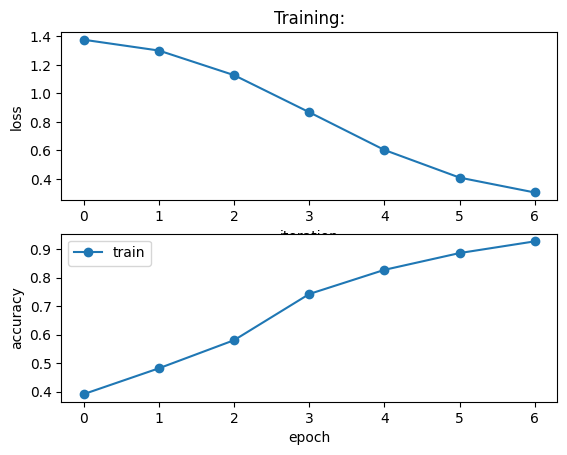

In [23]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training:')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
# plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Evaluation
Prediction using the testing set

In [24]:
from src.utils.model_utils import predict

In [25]:
if colab:
    test_file = "./data/proc/testing.parquet.gzip"
else:
    test_file = "./../../data/proc/testing.parquet.gzip"
test_df = pd.read_parquet(test_file)

x_test = test_df['title'].values
y_test = test_df['rating'].values.astype('int64')

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 363
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      357 non-null    object
 1   text    357 non-null    object
 2   title   357 non-null    object
 3   rating  357 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 13.9+ KB


In [27]:
prediction_dataloader = create_data_loader(x_test,
                                           y_test,
                                           bert_tokenizer,
                                           batch_size=32,
                                           sampler=SequentialSampler)

In [28]:
# Prediction on test set
predictions, true_labels, test_results_df = predict(bert_model, prediction_dataloader, test_df)


Prediction started


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 
  Accuracy: 0.53
 
  Precision: 0.49
 
  Recall: 0.53
 
  F1: 0.48
 
  Testing complete.
 


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
test_df.head()

id                                               text  \
0  81a67c96  Former state House Majority Leader Adam Hasner...   
1  6e5ec6fb  Editor’s note: Subsequent to this article, VTD...   
2  d9cd4895  The hypocritical Lib Dems want to ignore the r...   
3  4a1a9b9f  Urgent action to boost the number of children ...   
4  6d16fa40  By Ken Allen AFSCME Council 75 represents the ...   

                                               title  rating      true  \
0                              - The Washington Post       2  0.033050   
1                Rubio Comments on Iran Nuclear Deal       1  0.010041   
2  Climate Alarmists Caught Manipulating Temperat...       1  0.008263   
3  Who are the arsonists setting rural fires in W...       1  0.726485   
4  Diabetes prescriptions now cost NHS £1bn, figu...       1  0.032841   

      false  partially false     other final_prediction  
0  0.026187         0.692981  0.247783        tensor(2)  
1  0.917498         0.054163  0.018298        tensor(1)  
2  0.886139         0.062926  0.042672        tensor(1)  
3  0.066797         0.104894  0.101824        tensor(0)  
4  0.802961         0.051218  0.112981        tensor(1)

In [30]:
if colab:
    test_df.to_csv(f"drive/MyDrive/ift714/ift714-project/test_with_results_{feature}-CASED.csv")
else:
    test_df.to_csv(f"./../../data/outputs/test_with_results_{feature}-CASED.csv")

### Save the model's state

In [31]:
pwd

'/content'

In [32]:
if colab:
    torch.save(bert_model.state_dict(), "drive/MyDrive/ift714/ift714-project/bert-title-state.pt")
else:
    torch.save(bert_model.state_dict(), "./../models/bert-text-state.pt")